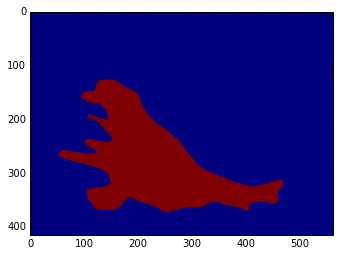

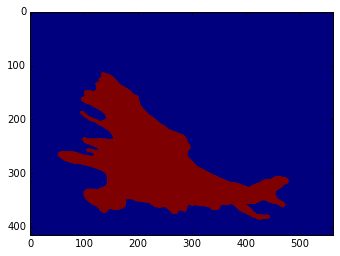

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
from scipy import ndimage
from PIL import Image
import glob

%matplotlib inline


im_paths = glob.glob('sampleTraces/trace*.jpg')
ims = list()
for path in im_paths:
    image = Image.open(path)
    # > 128 cause of jpg compression
    ims.append((np.asarray(image)[:,:,0] > 128))
    
im1 = ims.pop(6)
im2 = ims[0]

fig = plt.figure()
plt.imshow(im1)
fig = plt.figure()
plt.imshow(im2)

In [6]:
# Various measures of distance
# Assume im1 and im2 are binary images

def dice(im1, im2):
    # Sorensen-Dice coefficient
    # https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient
    return np.sum(im1==im2)*2.0 / (np.sum(im1) + np.sum(im2))
    
def mse(im1, im2):
    # Mean Squared Error AKA L2 loss
    # Lower is better
    return np.sqrt(np.sum(np.subtract(im1.astype('float64'), im2.astype('float64'))**2))

def manhattan(im1, im2): 
    # Manhattan distance AKA L1 loss
    # https://en.wikipedia.org/wiki/Taxicab_geometry
    return np.sum(np.abs(np.subtract(im1.astype('float64'), im2.astype('float64'))))

def dist_loss_l1(im1, im2):
    distmap = ndimage.distance_transform_edt(im1)+ ndimage.distance_transform_edt(im1==0)
    return np.sum(distmap[im1 != im2])

def dist_loss_l2(im1, im2):
    distmap = ndimage.distance_transform_edt(im1)+ ndimage.distance_transform_edt(im1==0)
    return np.sqrt(np.sum(distmap[im1 != im2]**2))

import skfmm
def get_geodesic_dist(im1, im2):
    #determines the shortest distance to travel from the consensus area to each point of the non-consensus area
    d1 = skfmm.distance(np.ma.MaskedArray(im1==0, ~im2)) 
    d2 = skfmm.distance(np.ma.MaskedArray(im2==0, ~im1))
    d_out = np.zeros(d1.shape)
    d_out[im2>0] = d1[im2>0]
    d_out[im1>0] = d_out[im1>0] + d2[im1>0]
    return d_out

def geodesic_distance_l1(im1, im2):
    return np.sum(get_geodesic_dist(im1, im2))

def geodesic_distance_l2(im1, im2):
    return np.sqrt(np.sum(get_geodesic_dist(im1, im2)**2))


print 'Dice: ', dice(im1, im2)
print 'MSE: ', mse(im1, im2)
print 'Manhattan: ', manhattan(im1, im2)
print 'dist_loss_l1: ', dist_loss_l1(im1, im2)
print 'dist_loss_l2: ', dist_loss_l2(im1, im2)
print 'geodesic_distance_l1: ', geodesic_distance_l1(im1, im2)
print 'geodesic_distance_l2: ', geodesic_distance_l2(im1, im2)


Dice:  5.35576674273
MSE:  77.2398860693
Manhattan:  5966.0
dist_loss_l1:  28106.1165302
dist_loss_l2:  543.402245119
geodesic_distance_l1:  27040.1810849
geodesic_distance_l2:  583.580692545


(<matplotlib.figure.Figure at 0x113096dd0>,
 <matplotlib.image.AxesImage at 0x1132412d0>)

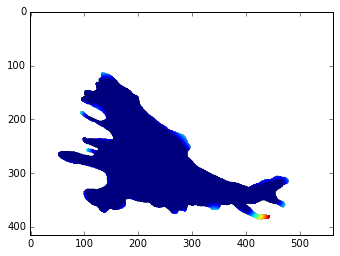

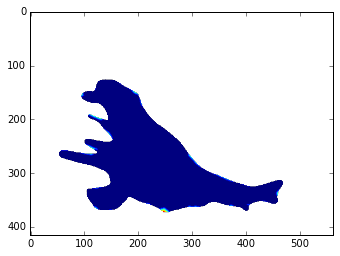

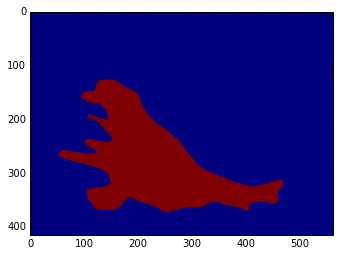

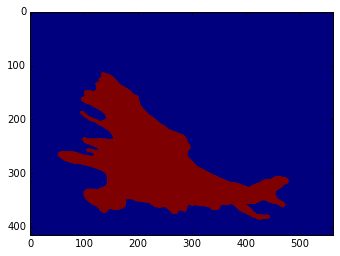

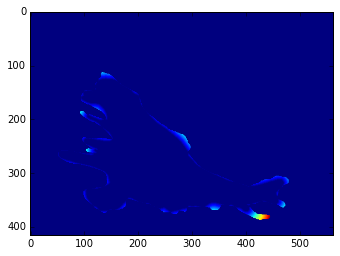

In [7]:
import skfmm


fig = plt.figure()
d1 = skfmm.distance(np.ma.MaskedArray(im1==0, ~im2)) 
d2 = skfmm.distance(np.ma.MaskedArray(im2==0, ~im1))
img = np.zeros(d1.shape)
img[im2>0] = d1[im2>0]
img[im1>0] = img[im1>0] + d2[im1>0]

plt.figure(), imshow(d1)
plt.figure(), imshow(d2)



plt.figure(), imshow(im1)
plt.figure(), imshow(im2)

d1 = skfmm.distance(np.ma.MaskedArray(im1==0, ~im2)) 
d2 = skfmm.distance(np.ma.MaskedArray(im2==0, ~im1))
d_out = np.zeros(d1.shape)
d_out[im2>0] = d1[im2>0]
d_out[im1>0] = d_out[im1>0] + d2[im1>0]
d_out[im1 & im2] = 0

plt.figure(), imshow(d_out)

0.0148749351501


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in divide


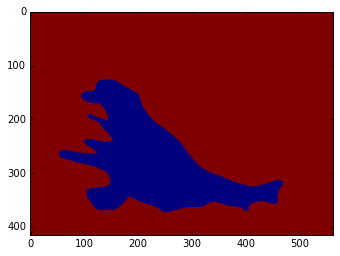

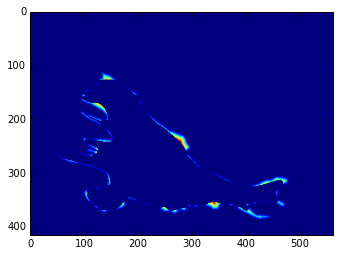

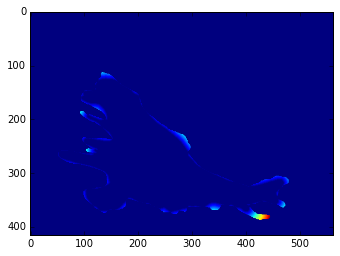

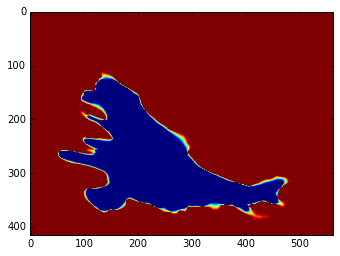

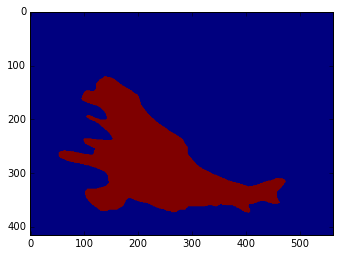

In [10]:
import time

plt.figure()
imshow(im1==0)

start = time.time()

din2 = skfmm.distance(np.ma.MaskedArray(im2==1, im2 & im1)) 
din1 = skfmm.distance(np.ma.MaskedArray(im1==1, im2 & im1))

d_in = np.zeros(d1.shape)
d_in[im1>0] = din1[im1>0]
d_in[im2>0] = d_in[im2>0] + din2[im2>0]

d_ratio = d_out/(d_in+d_out)
d_ratio[im1&im2] = 0
d_ratio[~im1 & ~im2] = 1

end = time.time()

print(end-start)

plt.figure()
imshow(d_in)

plt.figure()
imshow(d_out)

plt.figure()
imshow(d_ratio)

plt.figure()
imshow(d_ratio<=0.5)


In [1]:
import numpy as np
import pylab as plt
import skfmm

X, Y = np.meshgrid(np.linspace(-1,1,201), np.linspace(-1,1,201))
phi = -1*np.ones_like(X)

phi[X>-0.5] = 1
phi[np.logical_and(np.abs(Y)<0.25, X>-0.75)] = 1
plt.contour(X, Y, phi,[0], linewidths=(3), colors='black')
plt.title('Boundary location: the zero contour of phi')
plt.savefig('2d_phi.png')
plt.show()

d = skfmm.distance(phi, dx=1e-2)
plt.title('Distance from the boundary')
plt.contour(X, Y, phi,[0], linewidths=(3), colors='black')
plt.contour(X, Y, d, 15)
plt.colorbar()
plt.savefig('2d_phi_distance.png')
plt.show()

speed = np.ones_like(X)
speed[Y>0] = 1.5
t = skfmm.travel_time(phi, speed, dx=1e-2)

plt.title('Travel time from the boundary')
plt.contour(X, Y, phi,[0], linewidths=(3), colors='black')
plt.contour(X, Y, t, 15)
plt.colorbar()
plt.savefig('2d_phi_travel_time.png')
plt.show()

mask = np.logical_and(abs(X)<0.1, abs(Y)<0.5)
phi  = np.ma.MaskedArray(phi, mask)
t    = skfmm.travel_time(phi, speed, dx=1e-2)
plt.title('Travel time from the boundary with an obstacle')
plt.contour(X, Y, phi, [0], linewidths=(3), colors='black')
plt.contour(X, Y, phi.mask, [0], linewidths=(3), colors='red')
plt.contour(X, Y, t, 15)
plt.colorbar()
plt.savefig('2d_phi_travel_time_mask.png')
plt.show()

phi = -1 * np.ones_like(X)
phi[X > -0.5] = 1
phi[np.logical_and(np.abs(Y) < 0.25, X > -0.75)] = 1
d = skfmm.distance(phi, dx=1e-2, narrow=0.3)
plt.title('Distance calculation limited to narrow band')
plt.contour(X, Y, phi, [0], linewidths=(3), colors='black')
plt.contour(X, Y, d, 15)
plt.colorbar()
plt.savefig('2d_phi_distance_narrow.png')
plt.show()

In [7]:
import numpy as np
import pylab as plt
from skfmm import extension_velocities

N     = 150
X, Y  = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
r     = 1.75
dx    = 2.0 / (N - 1)
phi   = (X) ** 2 + (Y+1.85) ** 2 - r ** 2
speed = X+1.25

phi = np.ma.MaskedArray(im1==0, ~im2)
d, f_ext = extension_velocities(phi, 1, dx)



plt.subplot(131)
plt.title("Zero-contour of phi")
plt.contour(X, Y, phi,[0], colors='black', linewidths=(3))
plt.gca().set_aspect(1)

plt.subplot(132)
plt.title("Interface velocity")
plt.contour(X, Y, phi,[0], colors='black', linewidths=(3))
plt.contourf(X, Y, speed)
plt.gca().set_aspect(1)

plt.subplot(133)
plt.title("Extension velocities")
plt.contour(X, Y, phi,[0], colors='black', linewidths=(3))
plt.contourf(X, Y, f_ext)
plt.gca().set_aspect(1)

plt.show()

TypeError: extension_velocities() takes at least 2 arguments (1 given)